In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from math import pi
import numpy as np
import random

In [2]:
def balanced_part(num_q):
    # choose half the possible input strings
    qc = QuantumCircuit(num_q + 1)
    on_states = np.random.choice(
        range(2**num_q),  # numbers to sample from
        2**num_q // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    # we add a not gate before the bits we don't want to be a part of the key for flipping
    # so if those bits are on, the cx-gate is not triggered
    def add_xs(number):
        for i in range(0, num_q):
            if ((2**i) & number) == 0: # if i-th bit is on
                qc.x(i)
        
    for i in on_states:
        qc.barrier()
        add_xs(i)
        qc.mcx(list(range(num_q)), num_q)
        add_xs(i)
    return qc

In [3]:
def constant_part(num_q):
    qc = QuantumCircuit(num_q + 1)
    if random.randint(0,2) == 1: # do all ones
        qc.x(num_q)
    return qc

In [4]:
def dj_function(num_q, balanced):
    qc = QuantumCircuit(num_q + 1)

    if balanced == True:
        qc = qc.compose(balanced_part(num_q))
    else:
        qc = qc.compose(constant_part(num_q))

    qc.barrier()

    return qc

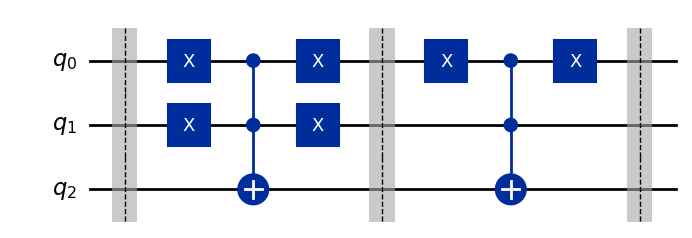

In [5]:
display(dj_function(2, True).draw(output="mpl"))

In [16]:
def compile_circuit(query_function):
    num_q = query_function.num_qubits - 1
    
    qc = QuantumCircuit(QuantumRegister(num_q + 1, "q"), ClassicalRegister(num_q, "a"))
    
    qc.x(num_q)
    # create first superposistion and minus state
    qc.h(range(0, num_q + 1))
    
    qc = qc.compose(query_function)

    qc.h(range(0, num_q + 1))

    qc.measure(range(0, num_q), range(0, num_q))
    return qc

In [17]:
def do_dj(num_q, balanced):
    return compile_circuit(dj_function(num_q, balanced))

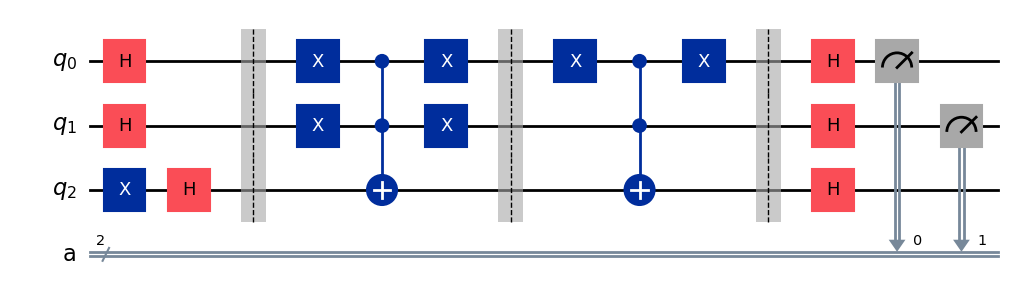

In [18]:
display(do_dj(2, True).draw(output="mpl"))

Measured 00000 with frequency 1024


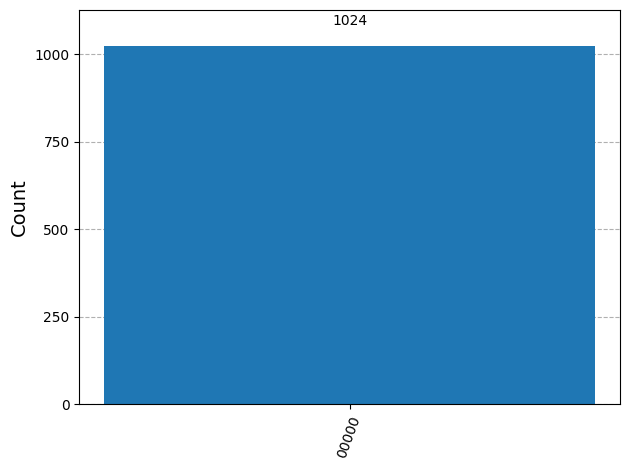

In [21]:
result = AerSimulator().run(do_dj(5, False)).result()
statistics = result.get_counts()
 
for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")
 
display(plot_histogram(statistics))